In [80]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split
# linearly transform a feature to zero mean and unit variance
from sklearn.preprocessing import StandardScaler

# to reload modules
import importlib

%matplotlib inline

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
#seed = 128
#rnd  = np.random.RandomState(seed)

from torch.utils.data import Dataset
import aliutils as utils

In [70]:
df = pd.read_csv('Data.csv')
df.head()

,Unnamed: 0,rawRecoDatapT,rawRecoDataeta,rawRecoDataphi,rawRecoDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,0,29.0586,3.511970,1.503010,5.69919,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,1,47.9465,0.776638,-1.251970,6.72517,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,2,29.5200,-1.084730,1.834230,4.06446,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,3,23.2719,-2.822960,0.216718,3.50878,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,4,30.4644,2.985000,1.306930,4.11101,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


In [71]:
df = df.iloc[:,5:]
df.head()

,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


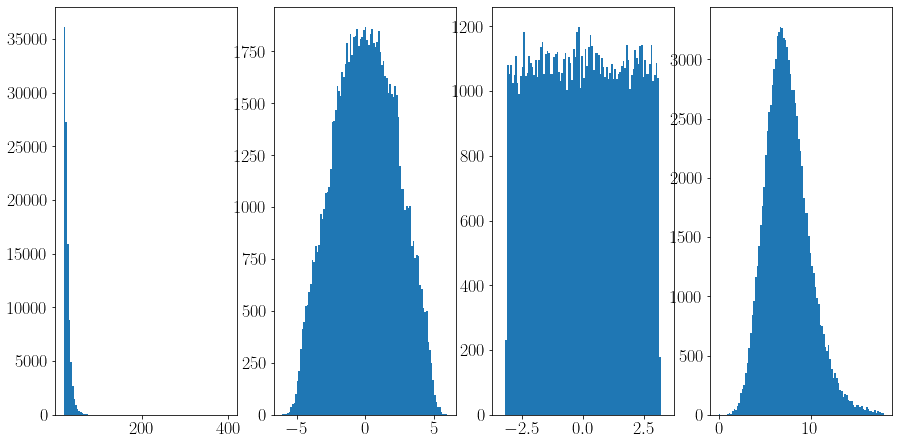

In [118]:
fig, ax = plt.subplots(1,4, figsize=(15,7.5))
ax[0].hist(df.RecoDatapT,bins=100)
ax[1].hist(df.RecoDataeta,bins=100)
ax[2].hist(df.RecoDataphi,bins=100, range=(-3.4,3.4))
ax[3].hist(df.RecoDatam,bins=100, range=(0,18))
plt.show()

In [72]:
levels = ['genData', 'RecoData']
kinematics=['pT','eta','phi','m']
targets = kinematics#for reco level, but same names
Networks = ['RecoNN', 'genNN']

target = df['RecoDatapT'].to_numpy()
data =  df.drop('RecoDatapT', axis=1).to_numpy()
data

array([[ 3.41479   ,  1.47023   , 12.5374    , ...,  1.47013   ,
        13.2444    ,  0.53652539],
       [ 3.41479   ,  1.47023   , 12.5374    , ..., -1.32412   ,
        10.5506    ,  0.13053623],
       [-1.17862   ,  1.84039   ,  9.95503   , ...,  1.80182   ,
         7.65844   ,  0.50016227],
       ...,
       [-1.49005   , -1.42238   , 11.155     , ...,  1.85921   ,
         8.8265    ,  0.11958587],
       [-0.654844  , -1.26413   ,  3.893     , ..., -1.21499   ,
         4.87261   ,  0.5541255 ],
       [-1.10686   ,  1.3181    ,  6.0953    , ...,  1.33004   ,
         3.94825   ,  0.05202467]])

In [73]:
target

array([40.3892, 40.3892, 29.3586, ..., 27.0034, 23.8815, 33.2208])

In [74]:
def split_t_x(df, target, source, scalers):
    # change from pandas dataframe format to a numpy array
    scaler_t, scaler_x = scalers
    t = np.array(scaler_t.transform(df[target].to_numpy().reshape(-1, 1)))
    x = np.array(scaler_x.transform(df[source]))
    t = t.reshape(-1,)
    return t, x

In [83]:
data    = pd.read_csv('Data.csv')
print('number of entries:', len(data))

columns = list(data.columns)[1:]
print('\nColumns:', columns)

fields  = list(data.columns)[5:]
print('\nFields:', fields)

target  = 'RecoDatapT'
print('\nTarget:', target )

features= [x for x in fields]
features.remove(target)

print('\nFeatures:', features)

data    = data[fields]
data[:5]

number of entries: 100000

Columns: ['rawRecoDatapT', 'rawRecoDataeta', 'rawRecoDataphi', 'rawRecoDatam', 'RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Fields: ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target: RecoDatapT

Features: ['RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']


,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,genDatapT,genDataeta,genDataphi,genDatam,tau
0,40.3892,3.41479,1.47023,12.53740,45.4608,3.379820,1.470130,13.24440,0.536525
1,40.3892,3.41479,1.47023,12.53740,56.2643,0.811412,-1.324120,10.55060,0.130536
2,29.3586,-1.17862,1.84039,9.95503,34.6377,-1.131020,1.801820,7.65844,0.500162
3,20.9593,2.13374,-2.86886,9.55921,27.4120,-2.842550,0.345529,5.18675,0.490624
4,35.2909,2.96499,1.36464,10.69580,30.3263,3.040300,1.341270,5.74890,0.417064


In [84]:
# Fraction of the data assigned as test data
fraction = 20/100
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 5/80
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         75000
validation set size:     5000
test set size:          20000


In [85]:

scaler_t = StandardScaler()
scaler_t.fit(train_data[target].to_numpy().reshape(-1, 1))

# create a scaler for inputs
scaler_x = StandardScaler()
scaler_x.fit(train_data[features])
# NB: undo scaling of tau, which is the last feature
scaler_x.mean_[-1] = 0
scaler_x.scale_[-1]= 1

scalers = [scaler_t, scaler_x]

In [86]:
train_targets, train_data = split_t_x(train_data, target, features, scalers)
valid_targets, valid_data = split_t_x(valid_data, target, features, scalers)
test_targets,  test_data  = split_t_x(test_data,  target, features, scalers)


In [87]:
sets= [train_data, test_data, train_targets, test_targets]
set_names = ['train_data', 'test_data', 'train_targets', 'test_targets']
for var_name, var in zip(set_names, sets):
    print(var_name 
          + ' shape = ', var.shape, '\n')

train_data shape =  (75000, 8) 

test_data shape =  (20000, 8) 

train_targets shape =  (75000,) 

test_targets shape =  (20000,) 



In [ ]:
%%writefile iqnutil.py

import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# return a batch of data for the next step in minimization
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)

# A simple wrapper around a model to make using the latter more
# convenient
class ModelHandler:
    def __init__(self, model, scalers):
        self.model  = model
        self.scaler_t, self.scaler_x = scalers
        
        self.scale  = self.scaler_t.scale_[0] # for output
        self.mean   = self.scaler_t.mean_[0]  # for output
        self.fields = self.scaler_x.feature_names_in_
        
    def __call__(self, df):
        
        # scale input data
        x  = np.array(self.scaler_x.transform(df[self.fields]))
        x  = torch.Tensor(x)

        # go to evaluation mode
        self.model.eval()
    
        # compute,reshape to a 1d array, and convert to a numpy array
        Y  = self.model(x).view(-1, ).detach().numpy()
        
        # rescale output
        Y  = self.mean + self.scale * Y
        
        if len(Y) == 1:
            return Y[0]
        else:
            return Y
        
    def show(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                print()
        
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

def plot_average_loss(traces, ftsize=18):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

Overwriting iqnutil.py


In [ ]:
# import iqnutil as ut
# importlib.reload(ut);

In [ ]:
# %%writefile iqn_model.py

# import torch
# import torch.nn as nn

# model = nn.Sequential(nn.Linear( 8, 50),
#                       nn.ReLU(),
                      
#                       nn.Linear(50, 50),
#                       nn.ReLU(),
                      
#                       nn.Linear(50, 50),
#                       nn.ReLU(), 
 
#                       nn.Linear(50, 50),
#                       nn.ReLU(), 
 
#                       nn.Linear(50, 1)) 

Overwriting iqn_model.py


In [44]:
# def split_t_x(df, target, source, scalers):
#     # change from pandas dataframe format to a numpy array
#     scaler_t, scaler_x = scalers
#     t = np.array(scaler_t.transform(df[target].to_numpy().reshape(-1, 1)))
#     x = np.array(scaler_x.transform(df[source]))
#     t = t.reshape(-1,)
#     return t, x

# # create a scaler for target
# scaler_t = StandardScaler()
# scaler_t.fit(train_data[target].to_numpy().reshape(-1, 1))

# # create a scaler for inputs
# scaler_x = StandardScaler()
# scaler_x.fit(train_data[features])
# # NB: undo scaling of tau, which is the last feature
# scaler_x.mean_[-1] = 0
# scaler_x.scale_[-1]= 1

# scalers = [scaler_t, scaler_x]

# train_t, train_x = split_t_x(train_data, target, features, scalers)
# valid_t, valid_x = split_t_x(valid_data, target, features, scalers)
# test_t,  test_x  = split_t_x(test_data,  target, features, scalers)

# train_t.shape, train_x.shape

In [94]:
class CustomDataset(Dataset):
    """This takes the index for the data and target and gives dictionary of tensors of data and targets.
    For example we could do train_dataset = CustomDataset(train_data, train_targets); test_dataset = CustomDataset(test_data, test_targets)
 where train and test_dataset are np arrays that are reshaped to (-1,1).
 Then train_dataset[0] gives a dictionary of samples "X" and targets"""
    def __init__(self, data, targets):
        self.data = data
        self.targets=targets
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        current_sample = self.data[idx, :]
        current_target = self.targets[idx]
        return {"x": torch.tensor(current_sample, dtype = torch.float),
               "y": torch.tensor(current_target, dtype= torch.float),
               }#this already makes the targets made of one tensor (of one value) each
    
train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets)
print(train_dataset[0], train_dataset)

{'x': tensor([ 0.8407,  0.7282, -0.3392, -0.6699,  1.3929, -0.9107, -0.3229,  0.7389]), 'y': tensor(-0.9520)} <__main__.CustomDataset object at 0x7efdaca2dc50>


In [95]:
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, num_workers=6)

In [96]:
import aliutils as utils

In [97]:
# n_examples, n_inputs = train_data.shape
# n_outputs, n_hidden = 1, 16
print('train_data.shape = ',train_data.shape)

train_data.shape =  (75000, 8)


In [98]:
model =  utils.RegressionModel(nfeatures=train_data.shape[1], 
               ntargets=1,
               nlayers=2, 
               hidden_size=4, 
               dropout=0.3)
print(model)

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [99]:
def train(optimizer, engine, early_stopping_iter, epochs, save_model=False):
    train_losses, test_losses = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    eng = utils.RegressionEngine(model=model, optimizer = optimizer)
    best_loss = np.inf
    early_stopping_iter = 10
    early_stopping_counter = 0
    # EPOCHS=22
    EPOCHS=epochs
    for epoch in range(EPOCHS):
        train_loss = eng.train(train_loader)
        test_loss = eng.evaluate(test_loader)
        print("Epoch : %-10g, Training Loss: %-10g, Test Loss: %-10g" % (epoch, train_loss, test_loss))
        #print(f"{epoch}, {train_loss}, {test_loss}")
        if test_loss < best_loss:
            best_loss = test_loss
            if save_model:
                torch.save(model.state_dict(), "goodmodel.pth")

        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_iter:
            #if we are not improving for 10 iterations then break the loop
            #we could save best model here
            break
    
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    train_losses=np.array(train_losses); test_losses=np.array(test_losses)
    
    fig = plt.figure(figsize=(5, 5))
    
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_title("Average loss")
    
    epoch_list = np.arange(1, train_losses.shape[0]+1)
    ax.plot(epoch_list, train_losses, label = 'Train')
    ax.plot(epoch_list, test_losses, label='Test')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    return train_losses, test_losses

    

Epoch : 0         , Training Loss: 0.321581  , Test Loss: 0.317432  
Epoch : 1         , Training Loss: 0.317684  , Test Loss: 0.318201  
Epoch : 2         , Training Loss: 0.31792   , Test Loss: 0.318045  
Epoch : 3         , Training Loss: 0.317462  , Test Loss: 0.317578  
Epoch : 4         , Training Loss: 0.317258  , Test Loss: 0.318549  
Epoch : 5         , Training Loss: 0.317749  , Test Loss: 0.317941  
Epoch : 6         , Training Loss: 0.317383  , Test Loss: 0.317655  
Epoch : 7         , Training Loss: 0.317595  , Test Loss: 0.318122  
Epoch : 8         , Training Loss: 0.317416  , Test Loss: 0.317984  
Epoch : 9         , Training Loss: 0.317216  , Test Loss: 0.316949  
Epoch : 10        , Training Loss: 0.31731   , Test Loss: 0.317428  
Epoch : 11        , Training Loss: 0.317704  , Test Loss: 0.318858  
Epoch : 12        , Training Loss: 0.317564  , Test Loss: 0.317559  


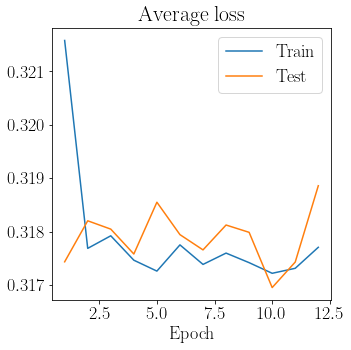

In [100]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
train_losses, test_losses=train(optimizer, 
      engine =utils.RegressionEngine(model=model, optimizer = optimizer),
      early_stopping_iter = 20,
      epochs=1000)

In [ ]:
np.array(train_losses).shape, np.array(test_losses).shape

In [246]:
# plt.plot(np.arange(1, train_losses.shape

In [88]:
def predict():
    outputs = []
    labels = []
    accuracies = []

    #evaluate
    with torch.no_grad():
        for data in test_loader:
            data_cp = copy.deepcopy(data)

            xtest = data_cp["x"]
            ytest = data_cp["y"]#y is Z values. I could add here my computed p-value for each theta,
            #and make a dataframe col1:theta, col2: Z, col3, phat, col4: computedp-value
            output = model(xtest)
            labels.append(ytest)
            outputs.append(output)

            y_predicted_cls = output.round()
            acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])# number of correct predictions/sizeofytest
            #accuracies.append(acc.numpy())
            #print(f'accuracy: {acc.item():.4f}')

            del data_cp

    #     acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])
    #     print(f'accuracy: {acc.item():.4f}')
            
    OUTPUTS = torch.cat(outputs).view(-1).numpy()

    LABELS = torch.cat(labels).view(-1).numpy()
    print('outputs of model: ', OUTPUTS)
    print('\nactual labels (targets Z): ', LABELS)
    return OUTPUTS.flatten(), LABELS.flatten()

In [89]:
OUTPUTS, LABELS = predict()

outputs of model:  [1. 1. 1. ... 1. 1. 1.]

actual labels (targets Z):  [30.2673 21.5886 31.447  ... 21.2377 24.5727 21.1226]


(array([1.8277e+04, 1.4950e+03, 1.8000e+02, 3.3000e+01, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([ 20.0008  ,  37.75662 ,  55.51244 ,  73.268265,  91.02408 ,
        108.7799  , 126.53572 , 144.29155 , 162.04736 , 179.80319 ,
        197.559   ], dtype=float32),
 <BarContainer object of 10 artists>)

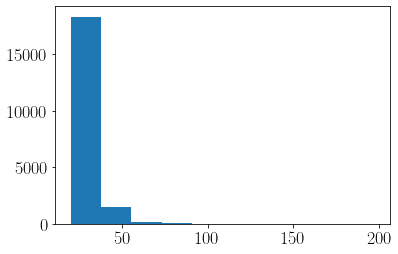

In [207]:
plt.hist(LABELS)

In [ ]:
def calc_phat_from_regressor(model, test_data):
    X_torch = torch.from_numpy(X).float()
    X_torch= Tensor(X_torch)
    model.eval()
    phat = model(X_torch)
    phat = phat.squeeze()
    phat=phat.detach().numpy().flatten()#detaches it from the computational history/prevent future computations from being tracked
    

----------

Now, assuming you have your plots in /images, look at them here

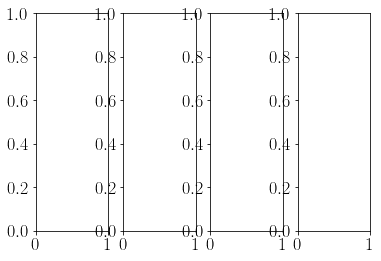

In [127]:
nrows=1; ncols=4
fig, axarr = plt.subplots(nrows, ncols)
kinematics =['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
img_paths = ['images/'+ k + '100k_IQN.png' for k in kinematics]
# for ax,im in zip(axarr.ravel(), img_paths):
#     ax.imshow(im)

TypeError: Image data of dtype <U29 cannot be converted to float

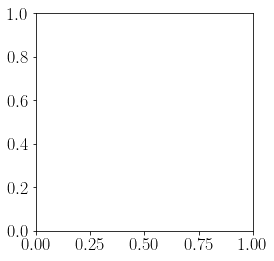

In [129]:
plt.imshow(img_paths[0])

In [ ]:
import pandas as pd
df = pd.read_csv('predicted_data/